In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
import random

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/brain-tumor-image-dataset-semantic-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/versions/1


In [ ]:
import kagglehub
from pycocotools.coco import COCO

# Download the latest version of the dataset
path = kagglehub.dataset_download("pkdarabi/brain-tumor-image-dataset-semantic-segmentation")

# Define paths to the dataset files
train_dir = f'{path}/train'
val_dir = f'{path}/valid'
test_dir = f'{path}/test'

train_annotation_file = f'{path}/train/_annotations.coco.json'
test_annotation_file = f'{path}/test/_annotations.coco.json'
val_annotation_file = f'{path}/valid/_annotations.coco.json'

# Load COCO annotations
train_coco = COCO(train_annotation_file)
val_coco = COCO(val_annotation_file)
test_coco = COCO(test_annotation_file)

print("Dataset downloaded and annotation files loaded.")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Dataset downloaded and annotation files loaded.


In [ ]:
def load_image_and_mask(coco, image_dir, image_id):
    #Retrieving image information from COCO
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])

    # Loading image
    image = Image.open(image_path)
    image = np.array(image, dtype=np.uint8)

    # Create mask
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask

In [ ]:
#Create Tensorflow dataset
def create_tf_dataset(coco, image_dir, image_ids):
    def generator():
        for image_id in image_ids:
            yield load_image_and_mask(coco, image_dir, image_id)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),  # Image
            tf.TensorSpec(shape=(None, None), dtype=tf.uint8)       # Mask
        )
    )

train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())

In [ ]:
def preprocess(image, mask):
    # Resizing
    image = tf.image.resize(image, (256, 256))

    # Adding a channel size to a mask
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (256, 256))

    # Normalization
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) # no normalization because masks are binary

    return image, mask

In [ ]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [ ]:
def visualize_dataset(dataset, num_samples=5):
    # Select a specific number of sample images and masks from the dataset
    for i, (image, mask) in enumerate(dataset.take(num_samples)):
        plt.figure(figsize=(10, 5))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title("Image")
        plt.axis("off")

        # Show mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.show()

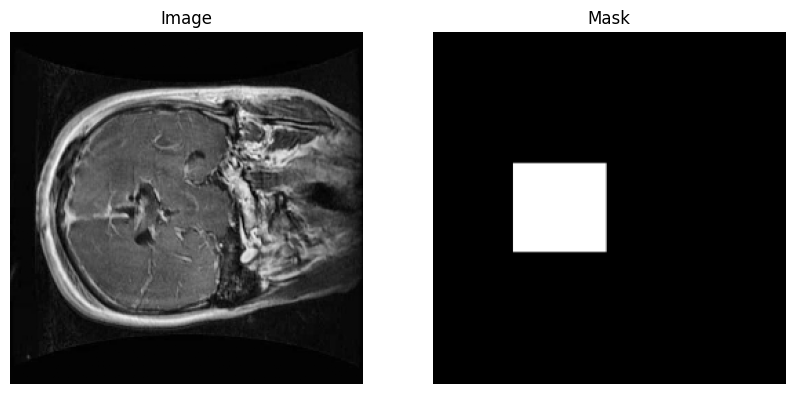

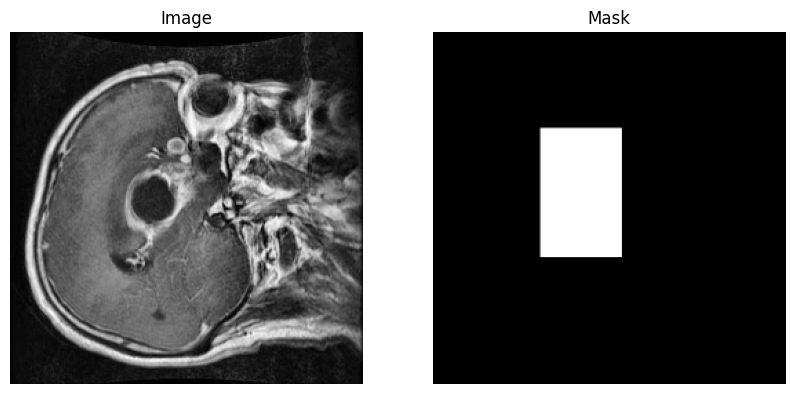

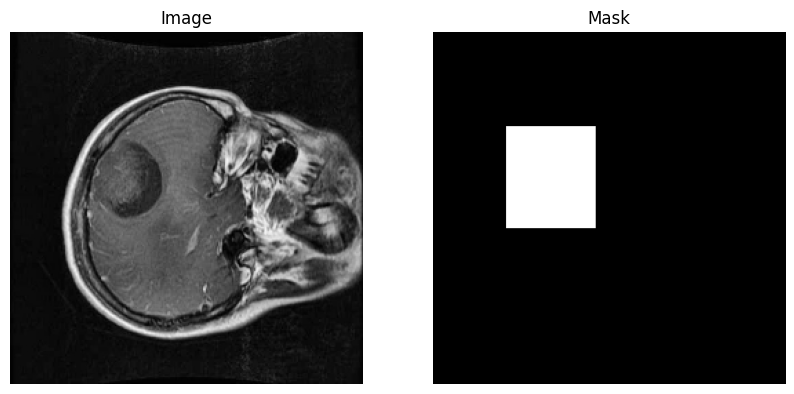

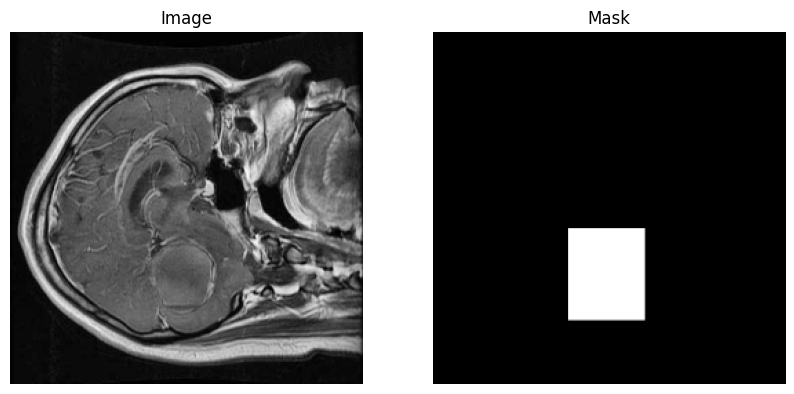

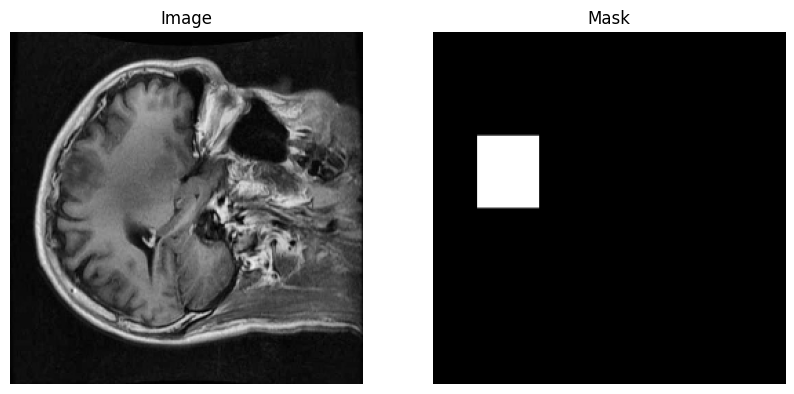

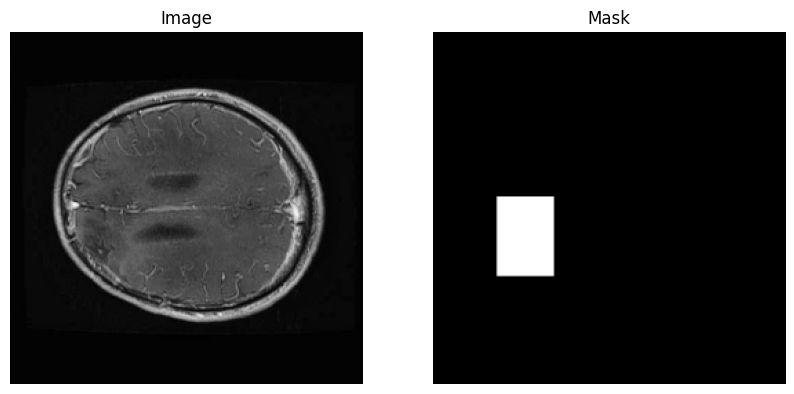

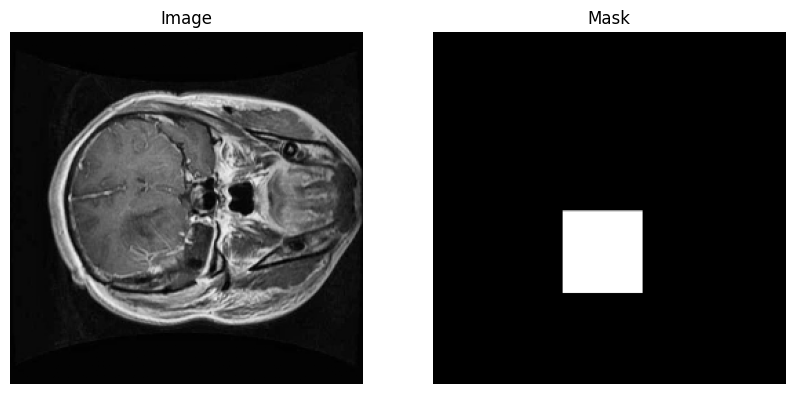

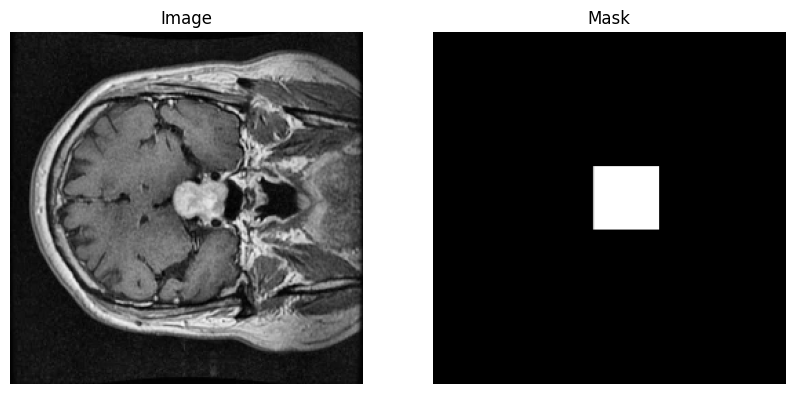

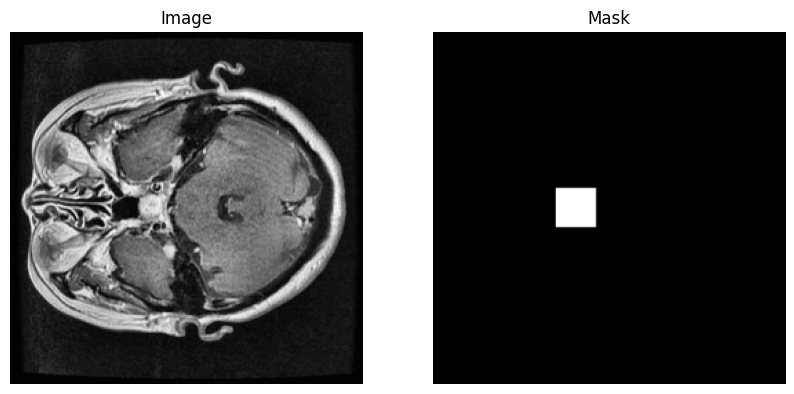

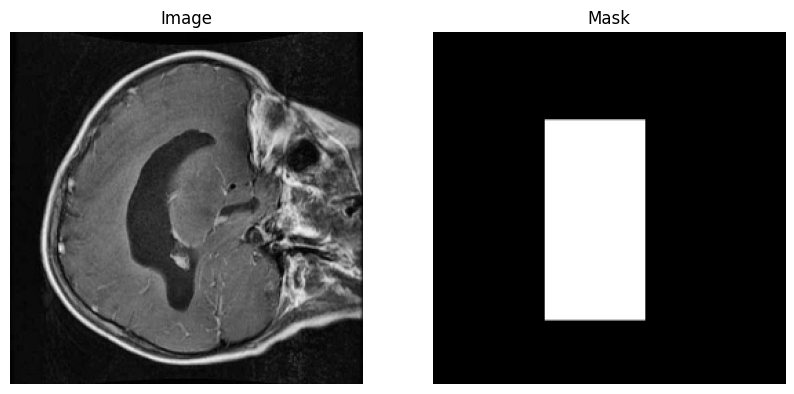

In [ ]:
# Visualize the training dataset
visualize_dataset(train_dataset)

# Visualize the validation dataset
visualize_dataset(val_dataset)

In [ ]:
from tensorflow.keras import layers

def attention_block(x, g, inter_filters):
    """
    Attention Gate that multiplies the features of the encoder by a learned attention map.

    Args:
        x: Encoder feature map (skip connection).
        g: Decoder feature map.
        inter_filters: Number of filters for the intermediate layers.

    Returns:
        Attention-weighted feature map.
    """
    # Convolution on the decoder feature map (g)
    g1 = Conv2D(inter_filters, 1, padding='same', kernel_initializer='he_normal')(g)
    g1 = BatchNormalization()(g1)
    g1 = ReLU()(g1)

    # Convolution on the encoder feature map (x)
    x1 = Conv2D(inter_filters, 1, padding='same', kernel_initializer='he_normal')(x)
    x1 = BatchNormalization()(x1)
    x1 = ReLU()(x1)

    # Element-wise sum of the transformed encoder and decoder feature maps
    sum_xg = layers.Add()([g1, x1])
    sum_xg = ReLU()(sum_xg)

    # Attention map
    attention = Conv2D(1, 1, padding='same', activation='sigmoid')(sum_xg)

    # Apply the attention mask to the encoder features
    return layers.Multiply()([x, attention])


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, Dropout, Add, Multiply
from tensorflow.keras.models import Model

def downsampling_block(inputs, n_filters, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    next_layer = MaxPooling2D(pool_size=(2, 2))(conv) if max_pooling else conv
    return next_layer, conv


def upsampling_block(inputs, skip_connection, n_filters):
    up = UpSampling2D(size=(2, 2))(inputs)
    up = Conv2D(n_filters, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up)
    up = BatchNormalization()(up)
    up = ReLU()(up)

    # Apply attention mechanism
    up = attention_block(skip_connection, up, n_filters)

    return up


def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1):
    """
    U-Net model with Attention mechanism.

    Args:
        input_size: Shape of the input tensor.
        n_filters: Number of filters for the convolutional layers.
        n_classes: Number of output classes.

    Returns:
        U-Net model with Attention.
    """
    inputs = Input(input_size)

    # Contracting Path (Encoder)
    dblock1 = downsampling_block(inputs, n_filters)
    dblock2 = downsampling_block(dblock1[0], n_filters * 2)
    dblock3 = downsampling_block(dblock2[0], n_filters * 4)
    dblock4 = downsampling_block(dblock3[0], n_filters * 8)
    dblock5 = downsampling_block(dblock4[0], n_filters * 16)

    # Bottleneck (no pooling, just convolutions)
    bblock6 = downsampling_block(dblock5[0], n_filters * 32, dropout_prob=0.4, max_pooling=False)

    # Expanding Path (Decoder)
    ublock7 = upsampling_block(bblock6[0], dblock5[1], n_filters * 16)
    ublock8 = upsampling_block(ublock7, dblock4[1], n_filters * 8)
    ublock9 = upsampling_block(ublock8, dblock3[1], n_filters * 4)
    ublock10 = upsampling_block(ublock9, dblock2[1], n_filters * 2)
    ublock11 = upsampling_block(ublock10, dblock1[1], n_filters)

    # Output Layer
    conv12 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock11)
    outputs = Conv2D(n_classes, 1, activation="sigmoid", padding="same")(conv12)

    return Model(inputs=inputs, outputs=outputs)


In [ ]:
model = unet_model(n_filters=32)


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Dice Coefficient (for evaluation)
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice coefficient, which is a measure of overlap between two binary images.

    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.
        smooth: Small constant to avoid division by zero.

    Returns:
        Dice coefficient value.
    """
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    # Compute intersection and union
    intersection = K.sum(y_true_flat * y_pred_flat)

    # Dice coefficient formula
    return (2. * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)


# Dice Loss (based on the Dice coefficient)
def dice_loss(y_true, y_pred):
    """
    Compute the Dice loss, which is the complement of the Dice coefficient.

    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.

    Returns:
        Dice loss value.
    """
    return 1 - dice_coefficient(y_true, y_pred)


# Combined Loss (weighted sum of Dice loss and Binary Crossentropy)
def combined_loss(y_true, y_pred):
    """
    Compute the combined loss, a weighted sum of Dice loss and Binary Crossentropy.

    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.

    Returns:
        Combined loss value.
    """
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # 60% Dice loss, 40% Binary Crossentropy
    return 0.6 * dice + 0.4 * bce


# Model Compilation
metrics = ["accuracy", dice_coefficient]

# Initial learning rate for the optimizer
initial_lr = 1e-4

# Adam optimizer with a given learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

# Compile the model
model.compile(optimizer=optimizer, loss=combined_loss, metrics=metrics)

# Display model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 128, 128, 32)   │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 64)     │              0 │ conv2d_27[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 128)    │              0 │ conv2d_29[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 16, 16, 256)    │              0 │ conv2d_31[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 8, 8, 512)      │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)   

 Total params: 22,387,046 (85.40 MB)

 Trainable params: 22,381,094 (85.38 MB)

 Non-trainable params: 5,952 (23.25 KB)

In [ ]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Optimizing datasets
train_dataset = train_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Steps calculating
steps_per_epoch = len(train_coco.getImgIds()) // BATCH_SIZE
validation_steps = len(val_coco.getImgIds()) // BATCH_SIZE
test_steps = len(test_coco.getImgIds()) // BATCH_SIZE
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    min_lr=1e-5,
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 75s 387ms/step - accuracy: 0.9144 - dice_coefficient: 0.0646 - loss: 0.7995 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0321 - val_loss: 0.7321 - learning_rate: 1.0000e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 333ms/step - accuracy: 0.9615 - dice_coefficient: 0.0731 - loss: 0.6770 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0159 - val_loss: 0.7138 - learning_rate: 1.0000e-04
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 446ms/step - accuracy: 0.9612 - dice_coefficient: 0.2378 - loss: 0.5168 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0013 - val_loss: 0.8597 - learning_rate: 1.0000e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step - accuracy: 0.9614 - dice_coefficient: 0.3184 - loss: 0.4604 - val_accuracy: 0.9627 - val_dice_coefficient: 0.0350 - val_loss: 0.7155 - learning_rate: 1.0000e-04
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 448ms/step - accuracy: 0.9616 - dice_coefficient: 0.3445 - loss: 0.4411 - val_accuracy: 0.9627 - v

In [ ]:
test_loss, test_accuracy, test_coef = model.evaluate(test_dataset, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Dice Coefficient: {test_coef}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9696 - dice_coefficient: 0.4027 - loss: 0.4051
Test Loss: 0.40020549297332764, Test Accuracy: 0.9703996181488037, Test Dice Coefficient: 0.40288859605789185


In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss graph
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy graph
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    # Select a random batch
    random_batch = random.choice(list(dataset))
    images, masks = random_batch

    # Select random indices for num_samples
    indices = random.sample(range(len(images)), min(num_samples, len(images)))

    predictions = model.predict(images)

    # Binarizing prediction masks
    binary_predictions = (predictions > threshold).astype('uint8')

    for i in indices:
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')

        # True mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(binary_predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

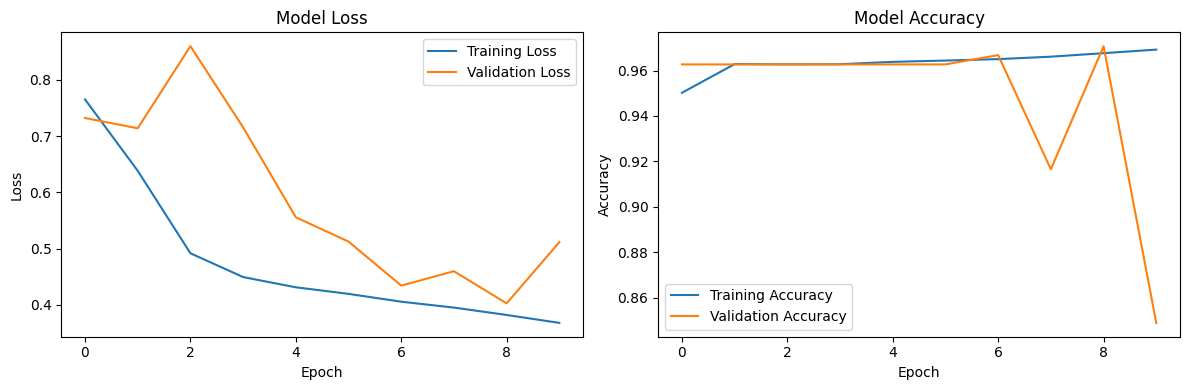

In [ ]:
plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


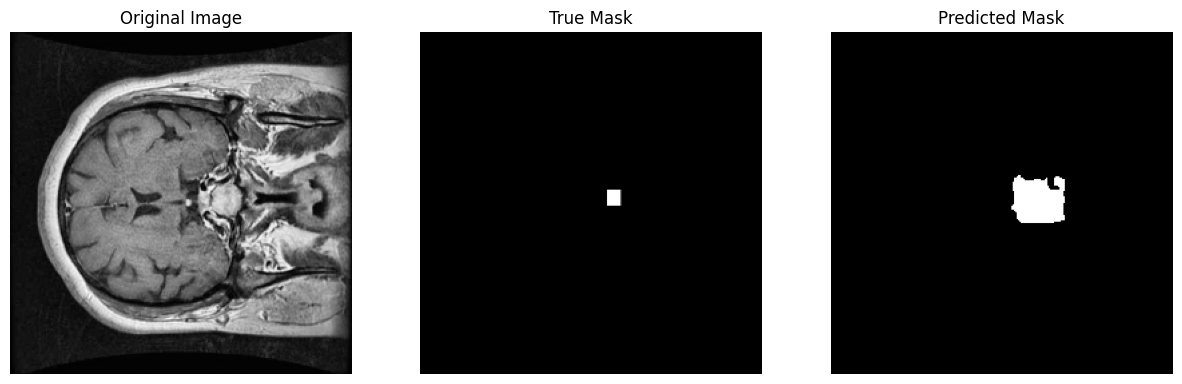

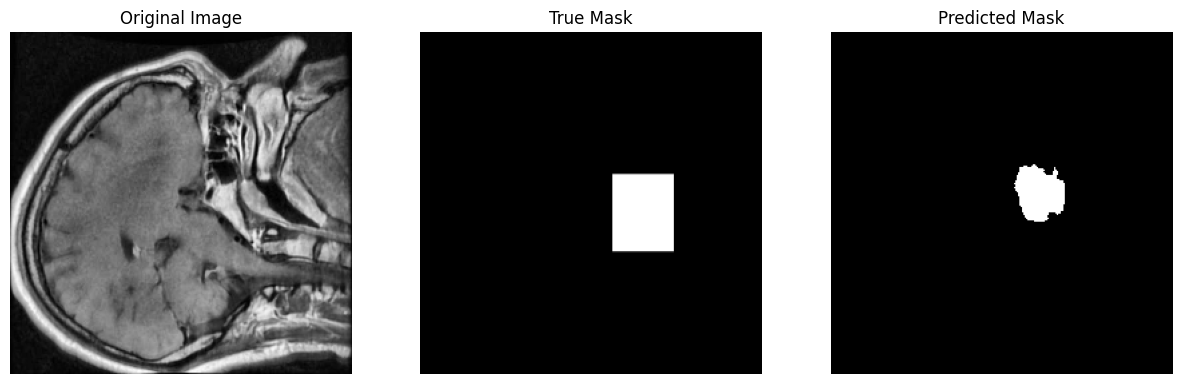

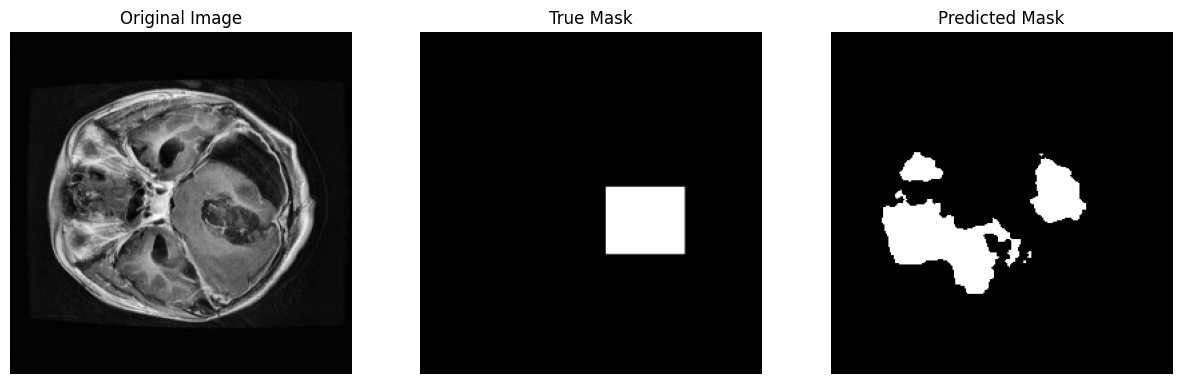

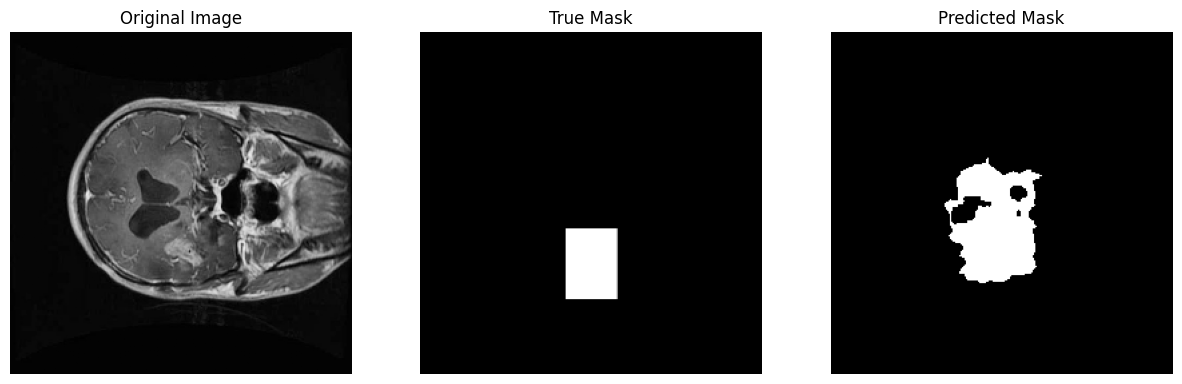

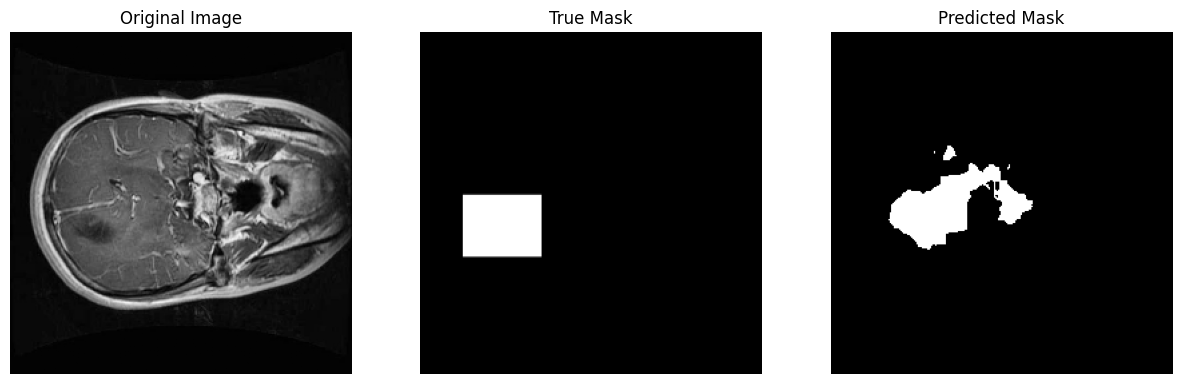

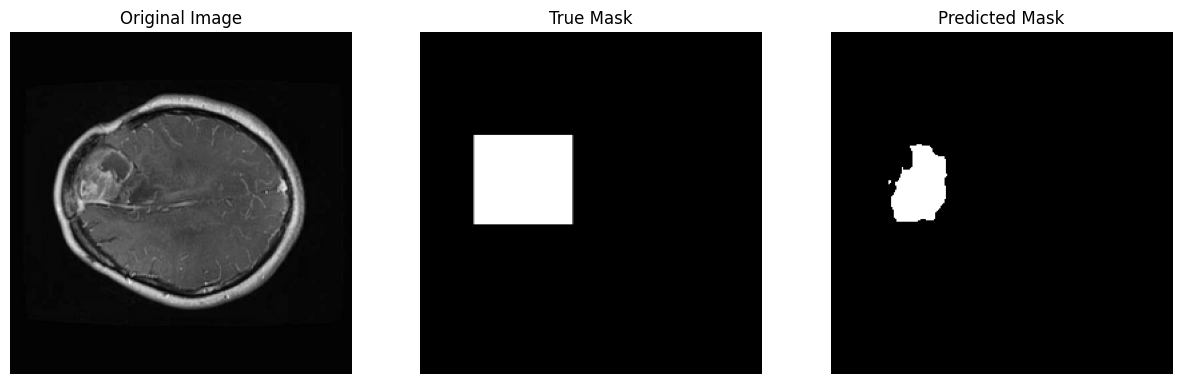

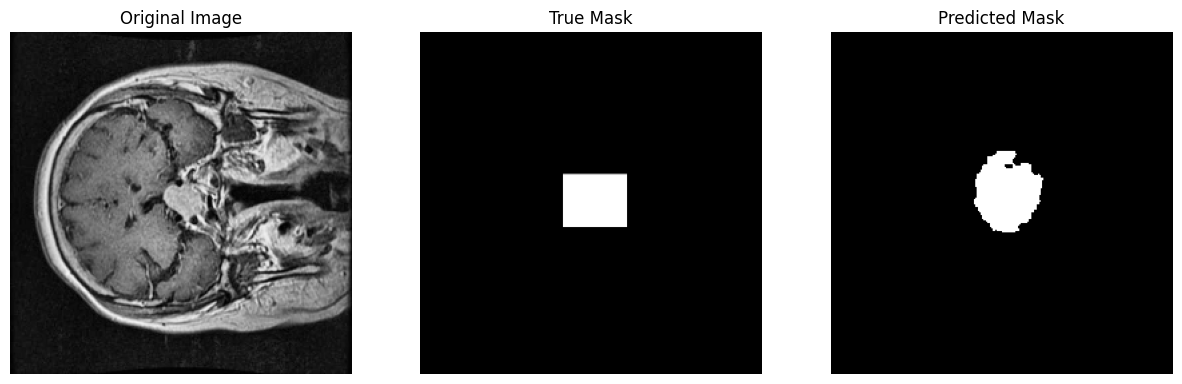

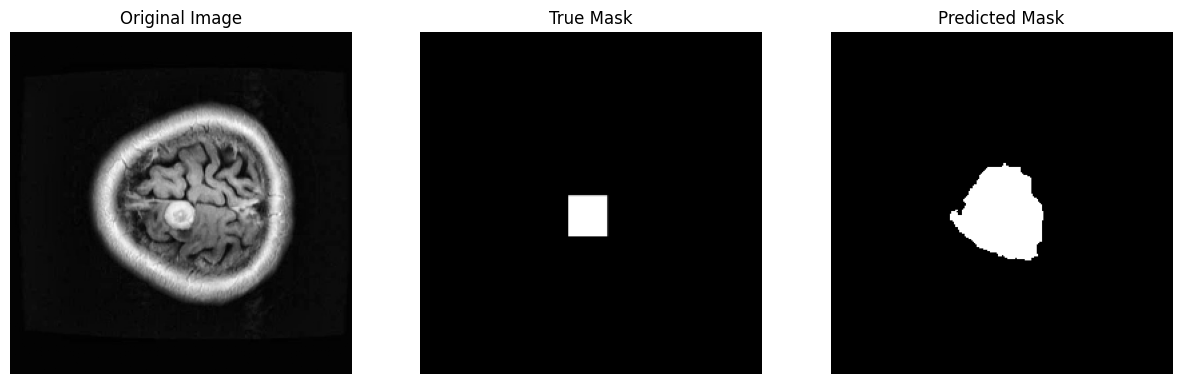

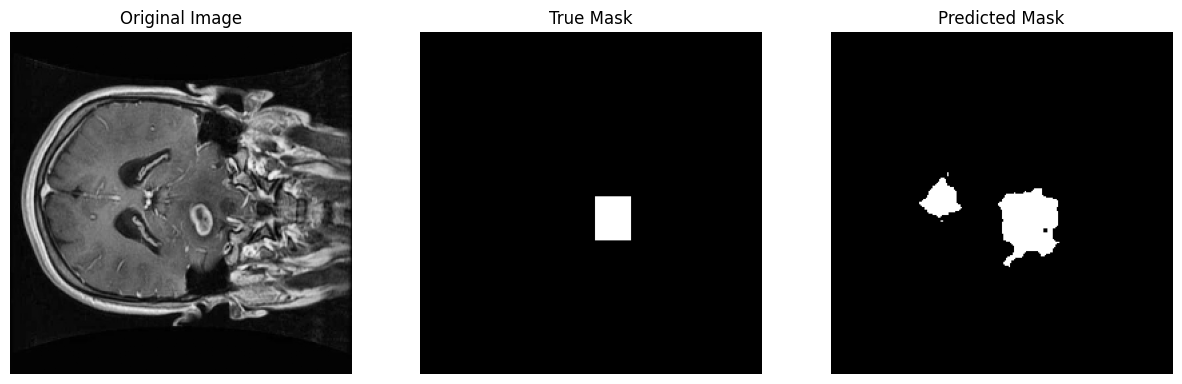

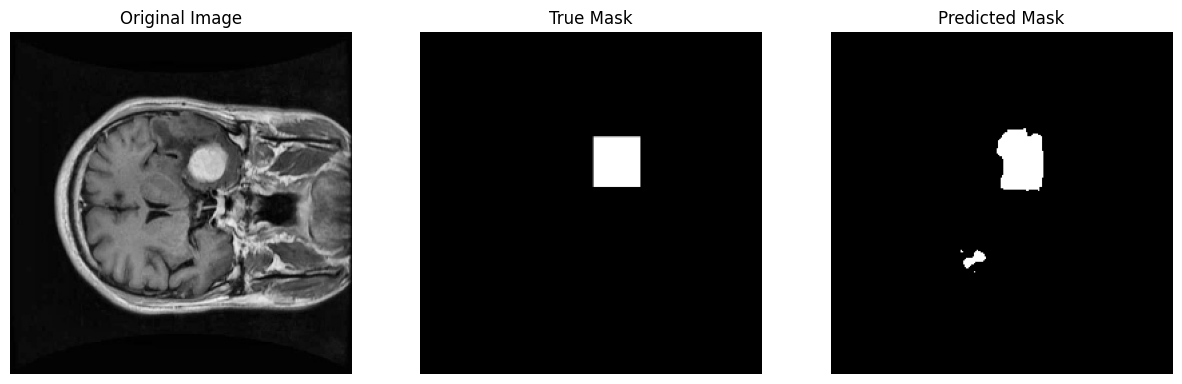

In [ ]:
visualize_predictions(model, test_dataset, num_samples=10)
